# Loading pretrained model and compute visual embeddings

This notebook is used to first load the pretrained CVM and then fed-forward screenshots to get their embeddings

In [1]:
import pandas as pd
import numpy as np 

import torch 
import torchvision.models as models
from torchvision import datasets, transforms
from torch import nn
from torch import optim

from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
# use gpu if available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print()
print("Device: ", device)


Device:  cuda:1


### Load model

In [3]:
# need the model to be defined in the notebook

out_dim = 13 # number of classes
features_dim = 512 # number of features before the classifier

class Webnet(nn.Module):
    def __init__(self):
        super(Webnet, self).__init__()
        
        resnet = models.resnet18(pretrained=True)
        
        self.features = torch.nn.Sequential(*list(resnet.children())[:-1])
        
        self.fc1 = torch.nn.Linear(features_dim, out_dim)
        
        self.drop = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.features(x).reshape(-1, features_dim)
        #x = self.drop(x)
        x = self.fc1(x)
        return x

In [4]:
# loading pretrained model
model = torch.load('/scratch/lugeon/webnets/webnet_29-12-20_10-40').to(device)

/scratch/lugeon/dl-env/lib/python3.8/site-packages/torch/serialization.py:622: UserWarning: Couldn't retrieve source code for container of type Webnet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [5]:
nb_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: {}".format(nb_trainable_params))

Number of parameters: 11183181


### Fed-forwarding screenshots

In [5]:
#path = '/dlabdata1/lugeon/dmozfinalset/dmoz_visual_screenshots/valid/'
path = '/dlabdata1/lugeon/dmozfinalset/dmoz_jap_screenshots'

batch_size = 64

# dimensions of the screeshots
valid_xdim = 640 # 640
valid_ydim = 360 # 360
crop_factor = 0.6

crop_dim = [int(crop_factor * valid_ydim), int(crop_factor * valid_xdim)]

five_crop = transforms.FiveCrop(size=crop_dim) 

tensorize = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

stack_norm_tensorize = transforms.Lambda(lambda crops: torch.stack([normalize(tensorize(crop)) for crop in crops]))


data_transforms = transforms.Compose([five_crop, stack_norm_tensorize])

images_dict = datasets.ImageFolder(path, data_transforms)
                                   
dataloader = torch.utils.data.DataLoader(images_dict, 
                                               batch_size=batch_size, 
                                               shuffle=False, 
                                               num_workers=4,
                                               pin_memory=True)                   

In [6]:
x = torch.zeros(len(dataloader) * batch_size, features_dim).to(device)
y_true = torch.zeros(len(dataloader) * batch_size, dtype=torch.long).to(device)
y_pred = torch.zeros(len(dataloader) * batch_size, dtype=torch.long).to(device)

model.eval()

with torch.no_grad():
    
    batch = 0

    for data in tqdm(iter(dataloader)):
        inputs = data[0].to(device)
        targets = data[1].to(device)
        bs, ncrops, c, h, w = inputs.size()
        outputs_ = model.features(inputs.view(-1, c, h, w)) # output for each crop
        
        preds_ = model.fc1(outputs_.view(-1, 512))
        
        outputs = outputs_.view(bs, ncrops, -1).mean(1) # mean over the crops
        preds = preds_.view(bs, ncrops, -1).mean(1) # mean over the crops
        preds = torch.argmax(preds, 1) # taking the argmax for the prediction
        
        n_samples = inputs.shape[0]
        
        x[batch*batch_size: batch*batch_size + n_samples,:] = outputs.detach()
        y_true[batch*batch_size: batch*batch_size + n_samples] = targets.detach()
        y_pred[batch*batch_size: batch*batch_size + n_samples] = preds.detach()

        del inputs 
        del targets
        del outputs
        del outputs_
        del preds
        
        batch += 1
    
    

100%|██████████| 114/114 [01:25<00:00,  1.33it/s]


In [7]:
# We need to extract the file names to get the uid
samples_uid = []

with torch.no_grad():
    for i, (images, labels) in enumerate(dataloader, 0):
        sample_fname, _ = dataloader.dataset.samples[i]
        sample_uid = sample_fname.split('/')[-1].split('.')[0]
        samples_uid += [sample_uid]

In [8]:
mask = torch.sum(x, 1).bool() # we created tensors a little too big, only keep non-zeros outputs
x = x[mask]
y_true = y_true[mask]
y_pred = y_pred[mask]

In [9]:
x.shape

torch.Size([7274, 512])

In [10]:
# accuracy of the prediction
(y_pred == y_true).sum().item() / y_pred.shape[0]

0.2305471542480066

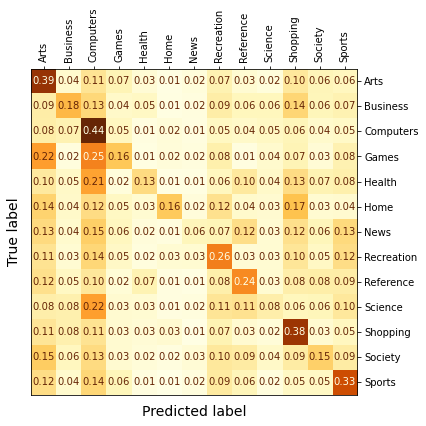

In [11]:
# We plot the confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

labels = [name for name in os.listdir(path)]


cm = confusion_matrix(y_true.cpu().numpy(), 
                      y_pred.cpu().numpy(),
                      normalize = 'true')

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=ax, cmap='YlOrBr', values_format='.2f', xticks_rotation='vertical')

plt.gca().images[-1].colorbar.remove()

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=True,      # ticks along the bottom edge are off
    labelright=True,
    left=False,
    labelleft=False) # labels along the bottom edge are off

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=True,      # ticks along the bottom edge are off
    labeltop=True,
    bottom=False,
    labelbottom=False,
    labelrotation=90) # labels along the bottom edge are off

ylab = plt.ylabel('True label', fontsize=14, labelpad=10)
xlab = plt.xlabel('Predicted label', fontsize=14, labelpad=10)

#xlab.set_position((0, 1))

plt.savefig('visual_test_cm.png', bbox_inches='tight')


plt.show()

We then store the embeddings and the uid in a dataframe and write it on the disk

In [12]:
samples_uid = [x[0].split('/')[-1].split('.')[0] for x in dataloader.dataset.samples]
len(samples_uid)

7274

In [13]:
graphical_embeddings = pd.DataFrame()

In [14]:
graphical_embeddings['uid'] = samples_uid
graphical_embeddings['embed_graph'] = x.tolist()

In [15]:
graphical_embeddings

,uid,embed_graph
0,1000872,"[0.8310052752494812, 1.4003973007202148, 0.588..."
1,1001757,"[0.35054153203964233, 0.4233723282814026, 0.59..."
2,1003869,"[0.6546453237533569, 0.934695839881897, 1.1079..."
3,1006029,"[0.9924761652946472, 0.2227269858121872, 0.356..."
4,1006193,"[0.08890047669410706, 0.011411063373088837, 0...."
...,...,...
7269,97649,"[0.6277844309806824, 0.6528472304344177, 0.326..."
7270,976735,"[1.8222026824951172, 0.3956385552883148, 0.188..."
7271,991941,"[0.10068609565496445, 0.09863107651472092, 0.0..."
7272,995325,"[0.761396586894989, 0.21173857152462006, 0.302..."


In [16]:
graphical_embeddings.to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_jap_visual_embeddings.gz', compression='gzip')

### Visualizing the embedding

In [23]:
#df_graph = pd.read_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_lang_visual_embeddings.gz', index_col=0)
#df_graph.head()
df_graph = graphical_embeddings

In [24]:
# need to convert the uid to int for merging
df_graph = df_graph.astype({'uid': 'int64'})

In [25]:
df_graph.head(1)

,uid,embed_graph
0,1000021,"[0.8024751543998718, 0.5643119215965271, 0.498..."


In [26]:
# dataframe that holds the category of the samples
df_cat = pd.read_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_lang_clean_urls.gz', index_col=0)

In [27]:
df_cat.head(1)

,uid,url,cat0
0,2424165,www.speech-and-phone.de,Computers


In [28]:
# we merge and sample by category
df_graph = df_graph.merge(df_cat[['uid', 'cat0']], on='uid', how='inner')
df_graph = df_graph.groupby('cat0').sample(200, random_state=42)
df_graph.reset_index(drop=True, inplace=True)

In [29]:
df_graph.head()

,uid,embed_graph,cat0
0,248637,"[0.8690873980522156, 0.8158363699913025, 0.569...",Arts
1,1809021,"[1.3097280263900757, 0.7806724309921265, 1.324...",Arts
2,541954,"[0.4932907223701477, 0.1355581134557724, 0.073...",Arts
3,1989411,"[0.42858821153640747, 0.6735662817955017, 0.28...",Arts
4,542324,"[0.5176305174827576, 0.3077441155910492, 0.344...",Arts


In [30]:
def convert_string_array(s):
    if type(s) == str:
        return np.fromstring(s[1:-1], sep=',') # need to remove the bracket for the method to work
    else:
        return s

In [31]:
x = np.concatenate(df_graph.embed_graph.apply(convert_string_array).to_numpy()).ravel()
x = x.reshape(-1, 512)
x.shape

(2600, 512)

In [32]:
import sklearn
from sklearn.manifold import TSNE

import umap

In [33]:
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x)

In [34]:
_umap = umap.UMAP(n_components=2)
x_umap = _umap.fit_transform(x)

In [37]:
x_proj = x_tsne

In [38]:
categories = np.sort(df_graph.cat0.unique())
categories

array(['Arts', 'Business', 'Computers', 'Games', 'Health', 'Home', 'News',
       'Recreation', 'Reference', 'Science', 'Shopping', 'Society',
       'Sports'], dtype=object)

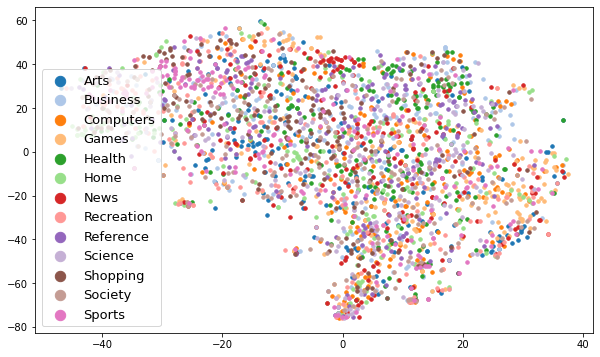

In [40]:
colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 12
marker = 'o'

fig, ax = plt.subplots(figsize=(10, 6))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df_graph[df_graph.cat0 == cat].index
    x_val = x_proj[ix][:,0]
    y_val = x_proj[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

#ax.set_xlim([-60,120])
#ax.set_ylim([-45,40])

#ax.set_xticks([], [])
#ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=3, fontsize=13)

plt.savefig('visual_test_embeddings.png')

plt.plot();